In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import theano
import numpy as np
import theano.tensor as T
from theano import shared, function

# Learning model parameters of LTI from Hankel matrices using the L2 loss

- Time-lagged covariances of an LTI can be expressed as $\Lambda(m) = C A^m \Pi C^\top$
- A very simple approach simply optimises $A,B,C$ by taking the squared error between the left- and right-hand side of the above equation
- Previously, gradients for this problem were worked out analytically. The approach does work, but did not yet scale well
- Stating the problem in Theano should allow to shove many of the involved linear algebra operations onto the GPU
- Right now, computing the gradients using Theano's symbolic differentiation
- Right now, no missing data

# Generate data, assuming infinite-data case 
- Generate ground-truth parameters $A, B, C$
- Compute time-lagged covariances $\Lambda(m)$, where $m\leq k+l-1$, from ground-truth parameters

In [2]:
p,n = 10, 3
k,l = 2,2

# Generate data, assuming infinite-data case: Compute covariance from ground-truth parameters

At = np.random.normal(size=(n,n))
At = At.dot(np.diag(np.linspace(0.1, 0.9, n))).dot(np.linalg.inv(At))
Bt = np.random.normal(size=(n,n))
Ct = np.random.normal(size=(p,n))
Qt = np.zeros((p,p,k+l-1))
for m_ in range(1,k+l):
    Qt[:,:,m_-1] = Ct.dot(np.linalg.matrix_power(At,m_).dot(Bt.dot(Bt.T))).dot(Ct.T)


# Write (symbolic) loss function & initialise parameters

In [3]:
# draw values from numpy
A0 = np.random.normal(size=(n,n))
A0 = A0.dot(np.diag(np.linspace(.3, .4, n))).dot(np.linalg.inv(A0))
B0 = np.random.normal(size=(n,n))
C0 = np.random.normal(size=(p,n))

# generate symbolic variables, initialise 
A, B, C = shared(A0), shared(B0), shared(C0)
Pi = T.dot(B, T.transpose(B))

# Write down cost function for k+l-1 many time-lags
cost = .5 * ((T.dot(C, T.dot(T.dot(A,Pi), T.transpose(C))) - np.squeeze(Qt[:,:,0]))**2).sum()
for m_ in range(2,k+l-1):
    
    # awkward way of symbolically defining a matrix power on the fly
    result, updates = theano.scan(fn=lambda prior_result, A: theano.tensor.dot(prior_result,A),
                                  outputs_info=T.identity_like(A),
                                  non_sequences=A,
                                  n_steps=m_)
    Am = final_result = result[-1]    
    
    cost += .5 * ((T.dot(C, T.dot(T.dot(Am,Pi), T.transpose(C))) - np.squeeze(Qt[:,:,m_-1]))**2).sum()

# Compute symbolic gradients, set fixed learning rates (to be replaced by AdaDelta or similar approach)
gA,gB,gC = T.grad(cost, [A,B,C])
train = function(inputs=[], outputs=cost, updates={A:A-0.0000001*gA, B:B-0.0000001*gB, C:C-0.0000001*gC})


/home/mackelab/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


# First steps towards learning the parameters
- very dumb, just following the gradients with fixed step size right now

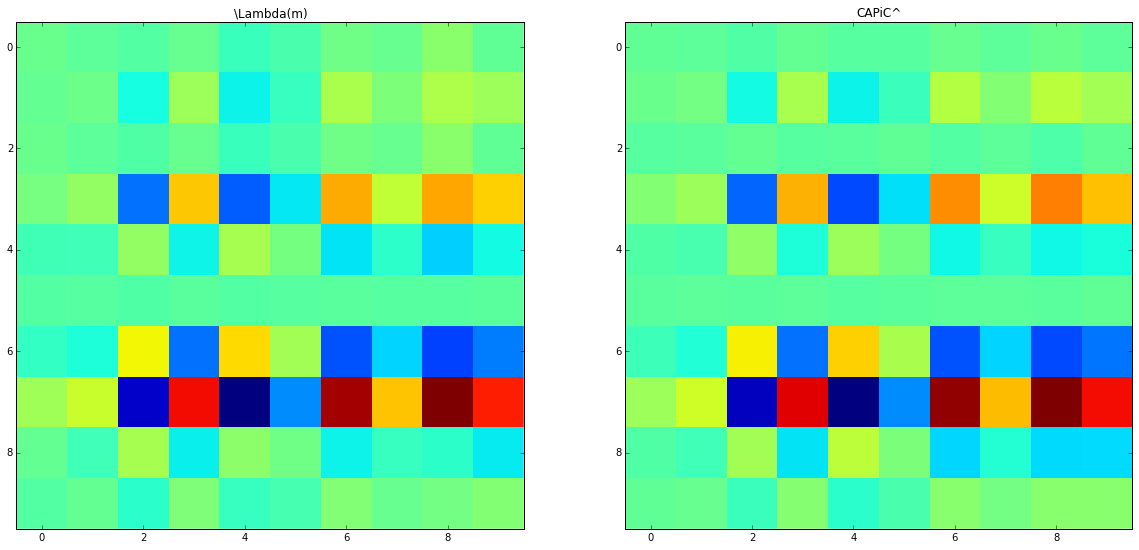

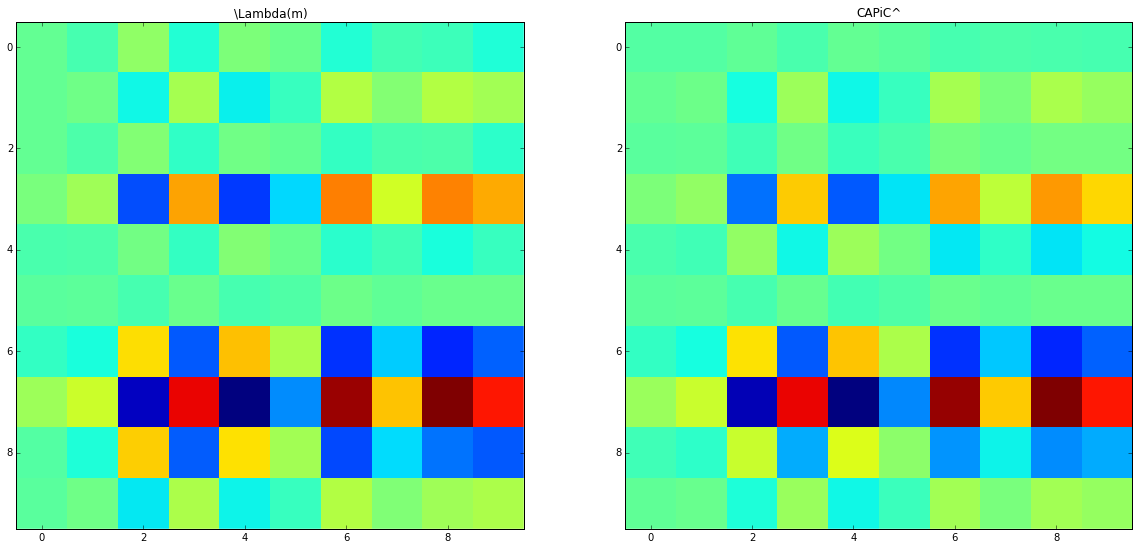

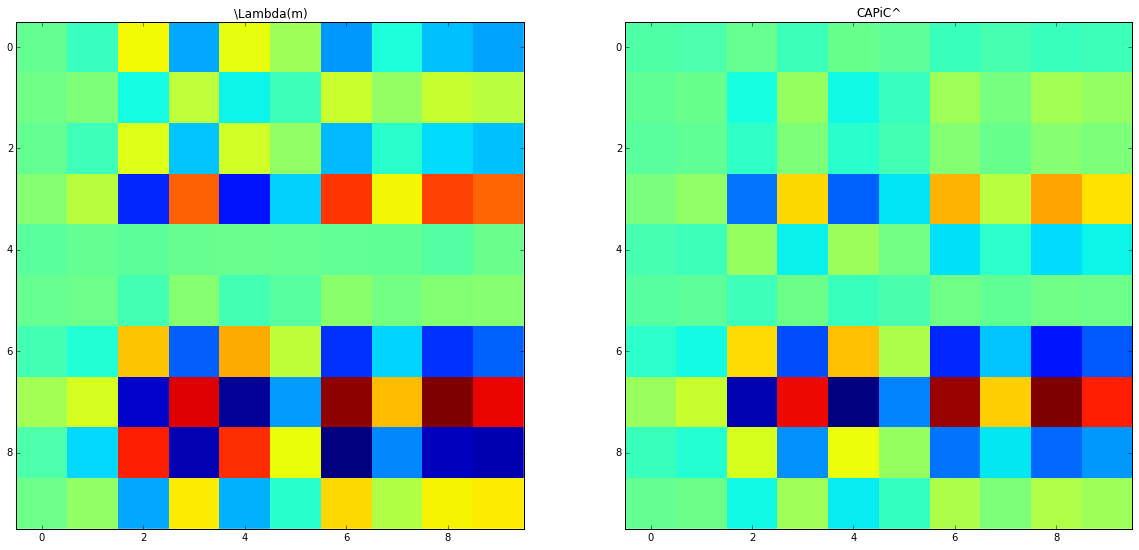

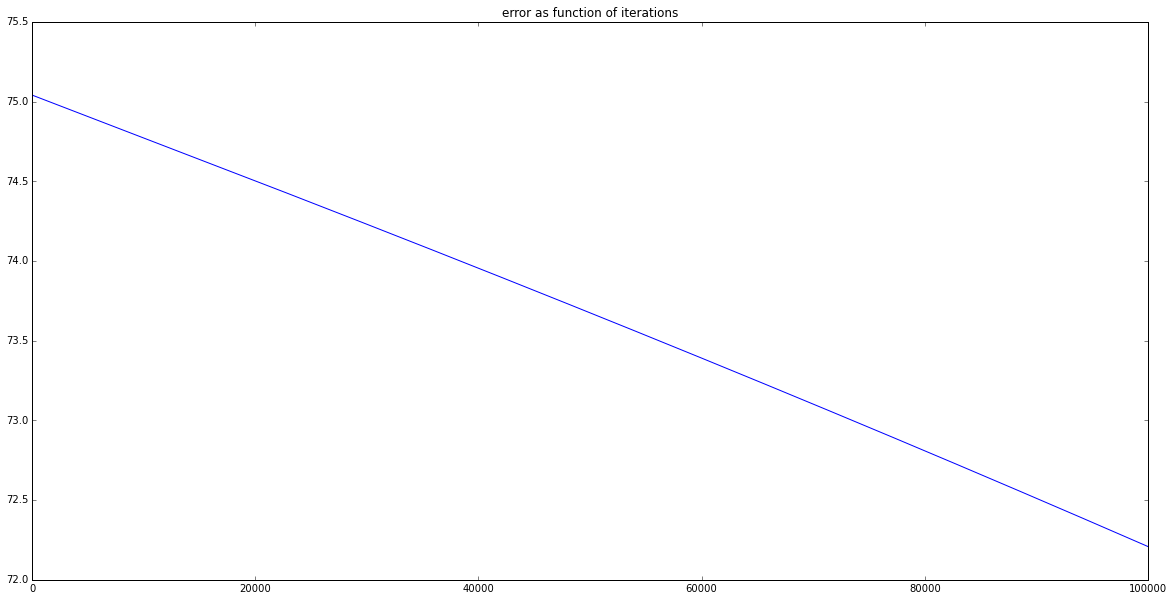

In [6]:
training_steps = 100000
err = np.zeros(training_steps)
for i in range(training_steps):
    err[i] = train()

for m in range(1,k+l):
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(Qt[:,:,m-1], interpolation='none')
    plt.title('\Lambda(m)')
    plt.subplot(1,2,2)
    A_est, B_est, C_est = A.get_value(), B.get_value(), C.get_value()
    plt.imshow(C_est.dot(np.linalg.matrix_power(A_est,m).dot(B_est.dot(B_est.T))).dot(C_est.T), interpolation='none')
    plt.title('CAPiC^')
    plt.show()

plt.figure(figsize=(20,10))
plt.plot(err)
plt.title('error as function of iterations')
plt.show()



# Technical checks

In [ ]:
# Check if GPU is used

from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

# Code bits for future use

In [ ]:
def adadelta(lr, tparams, grads, x, mask, y, cost):
    """
    An adaptive learning rate optimizer

    Parameters
    ----------
    lr : Theano SharedVariable
        Initial learning rate
    tpramas: Theano SharedVariable
        Model parameters
    grads: Theano variable
        Gradients of cost w.r.t to parameres
    x: Theano variable
        Model inputs
    mask: Theano variable
        Sequence mask
    y: Theano variable
        Targets
    cost: Theano variable
        Objective fucntion to minimize

    Notes
    -----
    For more information, see [ADADELTA]_.

    .. [ADADELTA] Matthew D. Zeiler, *ADADELTA: An Adaptive Learning
       Rate Method*, arXiv:1212.5701.
    """

    zipped_grads = [theano.shared(p.get_value() * numpy_floatX(0.),
                                  name='%s_grad' % k)
                    for k, p in tparams.items()]
    running_up2 = [theano.shared(p.get_value() * numpy_floatX(0.),
                                 name='%s_rup2' % k)
                   for k, p in tparams.items()]
    running_grads2 = [theano.shared(p.get_value() * numpy_floatX(0.),
                                    name='%s_rgrad2' % k)
                      for k, p in tparams.items()]

    zgup = [(zg, g) for zg, g in zip(zipped_grads, grads)]
    rg2up = [(rg2, 0.95 * rg2 + 0.05 * (g ** 2))
             for rg2, g in zip(running_grads2, grads)]

    f_grad_shared = theano.function([x, mask, y], cost, updates=zgup + rg2up,
                                    name='adadelta_f_grad_shared')

    updir = [-tensor.sqrt(ru2 + 1e-6) / tensor.sqrt(rg2 + 1e-6) * zg
             for zg, ru2, rg2 in zip(zipped_grads,
                                     running_up2,
                                     running_grads2)]
    ru2up = [(ru2, 0.95 * ru2 + 0.05 * (ud ** 2))
             for ru2, ud in zip(running_up2, updir)]
    param_up = [(p, p + ud) for p, ud in zip(tparams.values(), updir)]

    f_update = theano.function([lr], [], updates=ru2up + param_up,
                               on_unused_input='ignore',
                               name='adadelta_f_update')

    return f_grad_shared, f_update